# Imports

In [5]:
import datetime
import glob
import itertools
import json
import os
import pickle
import random
import re
from string import punctuation

In [52]:
import statistics

import fuzzywuzzy
import geopandas as gpd
import humanize
import janitor
import missingno as msno
import numpy as np
import pandas as pd
import recordlinkage
import scipy as sp
import statsmodels.formula.api as smf
from pandas_profiling import ProfileReport

In [7]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
px.set_mapbox_access_token(os.getenv("MAPBOX_TOKEN"))
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
plt.rcParams["figure.figsize"] = 15, 6
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [10]:
from mlxtend.plotting import plot_decision_regions
from sklearn import __version__ as sklearn_version
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
                              GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor,
                              VotingClassifier)
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, plot_precision_recall_curve,
                             precision_recall_curve, r2_score, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import (GridSearchCV, KFold, cross_val_score,
                                     cross_validate, learning_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (LabelEncoder, MaxAbsScaler, MinMaxScaler, Normalizer,
                                   StandardScaler, normalize, scale)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# GPU Check

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import torch
from tensorflow.python.client import device_lib

hello = tf.constant("Hello, TensorFlow!")
with tf.device("/gpu:0"):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name="a")
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name="b")
    c = tf.matmul(a, b)
print("-" * 20)
print("<<< Testing Tensorflow >>>")
print("<<< Version: ", tf.__version__)
print("<<< Eager mode: ", tf.executing_eagerly())
print("<<< Hub version: ", hub.__version__)
print(
    "<<< GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE",
)
print("<<< Code check...")
tf.print(hello)
tf.print(c)
print("-" * 20)

# torch
print("-" * 20)
print("<<< Testing Torch >>>")
print(f"<<< Version: {torch.__version__}")
print(
    "<<< GPU is",
    "available"
    if any("GPU" in d.name for d in device_lib.list_local_devices())
    else "NOT AVAILABLE",
)
print("<<< CUDA is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
print("<<< Code check...")
x = torch.rand(5, 3)
print(x)
print("-" * 20)


--------------------
<<< Testing Tensorflow >>>
<<< Version:  2.6.0
<<< Eager mode:  True
<<< Hub version:  0.12.0
<<< GPU is available
<<< Code check...
Hello, TensorFlow!
[[22 28]
 [49 64]]
--------------------
--------------------
<<< Testing Torch >>>
<<< Version: 1.9.0+cu102
<<< GPU is available
<<< CUDA is available
<<< Code check...
tensor([[0.8608, 0.0224, 0.1433],
        [0.4398, 0.7782, 0.0802],
        [0.1110, 0.6208, 0.4221],
        [0.9900, 0.5600, 0.2339],
        [0.9572, 0.7307, 0.8703]])
--------------------


2021-09-28 13:54:28.145580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 2567 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:07:00.0, compute capability: 7.5


# Functions

# Data

In [108]:
# load data and use pyjanitor to clean
train_df = pd.read_csv("datasets/trainingdata.csv", index_col=0).clean_names().remove_empty()
test_df = pd.read_csv("datasets/testdata.csv", index_col=0).clean_names().remove_empty()

/home/kcavagnolo/.pyenv/versions/3.8.0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [110]:
train_df.sample(5)

,function,use,sharing,reporting,student_type,position_type,object_type,pre_k,operating_status,object_description,...,sub_object_description,location_description,fte,function_description,facility_or_department,position_extra,total,program_description,fund_description,text_1
280647,Facilities & Maintenance,O&M,School Reported,School,Unspecified,Custodian,Benefits,NO_LABEL,PreK-12 Operating,RETIREMENT CONTRIB.,...,NaN,NaN,NaN,EMPLOYEE RETIREMENT,NaN,UNDESIGNATED,81.56000,EMPLOYEE BENEFITS,NaN,EMPLOYEE BENEFITS
261705,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,NO_LABEL,PreK-12 Operating,SALARIES OF REGULAR EMPLOYEES,...,NaN,NaN,NaN,ELA E-TEACHING SHELTERED ENG,NaN,PROFESSIONAL-INSTRUCTIONAL,2935.20992,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION
335414,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Other Pupil Transportation Services,...,Pupil Transportation *,NaN,NaN,Instruction And Curriculum Development Services *,NaN,NaN,-970.03000,NaN,Special Trust,ITEMAC-MOTIVATION
361549,Food Services,O&M,School Reported,School,Unspecified,Coordinator/Manager,Benefits,NO_LABEL,PreK-12 Operating,RETIREMENT CONTRIB.,...,NaN,NaN,NaN,EMPLOYEE RETIREMENT,NaN,UNDESIGNATED,358.62000,EMPLOYEE BENEFITS,NaN,EMPLOYEE BENEFITS
58014,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,ELA E-TEACHING SHELTERED ENG,NaN,PROFESSIONAL-INSTRUCTIONAL,1713.37000,GENERAL ELEMENTARY EDUCATION,NaN,REGULAR INSTRUCTION


In [65]:
# inspect
profile_report = train_df.profile_report(sort=None,
                                         explorative=True,
                                         html={"style": {
                                             "full_width": True
                                         }},
                                         progress_bar=True)
profile_report.to_file("docs/train_profile.html")

Summarize dataset:   0%|          | 0/38 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [111]:
# look for possible categorical columns
MIN_CATEGORIES = 2
MAX_CATEGORIES = 40
categorical_cols = []
print("Possibly categorical columns...")   
for col in train_df.select_dtypes(include=["object"]).columns:
    if MIN_CATEGORIES < len(train_df[col].value_counts()) < MAX_CATEGORIES:
        categorical_cols.append(col)
        print(f"   {col}")
if len(categorical_cols) == 0:
    print("   None")

Possibly categorical columns...
   function
   use
   sharing
   reporting
   student_type
   position_type
   object_type
   pre_k
   operating_status
   text_3


In [112]:
# change the column type using pyjanitor
categorical_cols.remove("text_3")
categorize_feature = lambda x: x.astype("category")
train_df[categorical_cols].apply(categorize_feature, axis=0)
train_df.sample(5)

,function,use,sharing,reporting,student_type,position_type,object_type,pre_k,operating_status,object_description,...,sub_object_description,location_description,fte,function_description,facility_or_department,position_extra,total,program_description,fund_description,text_1
284395,Aides Compensation,Instruction,School Reported,School,NO_LABEL,TA,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,...,NaN,NaN,1.0,NaN,NaN,SCHOOL ASST - ISS,21594.310000,ALTERNATIVE EDUCATION PROGRAM,General Fund,NaN
179303,Substitute Compensation,Instruction,School Reported,School,Special Education,Substitute,Substitute Compensation,Non PreK,PreK-12 Operating,Personal Services - Substitute Teachers Certified,...,NaN,NaN,0.0,NaN,NaN,SUBSTITUTE TEACHER,425.360000,Instruction - SPED,General Purpose School,NaN
327737,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Instructional Improvement Services,...,Professional And Technical Services *,NaN,NaN,Evaluation Services,NaN,NaN,-3424.480000,NaN,Title I - Disadvantaged Children/Targeted Assi...,ESEA TITLE I
386671,Curriculum Development,ISPD,Leadership & Management,Non-School,Gifted,School Monitor/Security,Other Compensation/Stipend,NO_LABEL,PreK-12 Operating,SALARIES FOR OVERTIME,...,NaN,GIFTED AND TALENTED,NaN,DESTINATION IMAGINATION,NaN,OFFICE/ADMINISTRATIVE SUPPORT,467.220000,SCHOOL SECURITY,NaN,OPERATION AND MAINT OF PLANT
396960,Extended Time & Tutoring,Instruction,School Reported,School,Special Education,Teacher,Other Compensation/Stipend,Non PreK,PreK-12 Operating,Salaries And Wages For Teachers And Other Prof...,...,Extended Week,School,NaN,Instruction,Instruction And Curriculum,TEACHER BACHELOR,266.843533,"""Title I, Part A Schoolwide Activities Related...","""Title Part A Improving Basic Programs""",MISCELLANEOUS


Text(0, 0.5, 'Number of unique values')

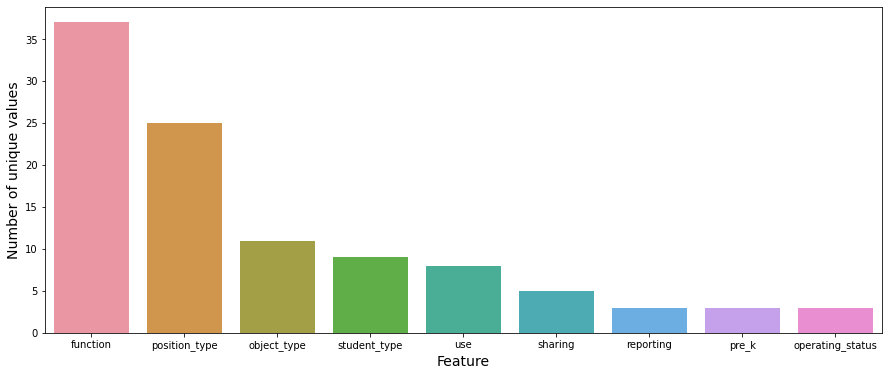

In [136]:
# display unique values for each feature
n_unique_features = train_df[categorical_cols].apply(pd.Series.nunique).sort_values(ascending=False)
sns.barplot(x=n_unique_features.index, y=n_unique_features.values)
plt.xlabel('Feature')
plt.ylabel('Number of unique values')